<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<b>CET Template Notebook</b> <br>
Contact author(s): <i>Author Name</i> <br>
Last verified to run: <i>yyyy-mm-dd</i> <br>
LSST Science Piplines version: Weekly <i>yyyy_xx</i> <br>
Container Size: <i>medium</i> <br>
Targeted learning level: <i>beginner</i> <br>

_In this template, text in italics are examples or instructions that should be: (a) removed if it is not applicable to the notebook; or (b) replaced with text that is appropriate for the notebook. But bold or regular text should appear pretty much as-is in all CET notebooks. For more information, see the [CET's Guidelines for Tutorial Notebooks](https://confluence.lsstcorp.org/pages/viewpage.action?pageId=168857070)._

_While developing, use the following code cell to check that the code conforms to standards, but then delete the cell and "Kernel --> Restart Kernel and Clear All Outputs" before saving and committing._

In [23]:
#%load_ext pycodestyle_magic
#%flake8_on
#import logging
#logging.getLogger("flake8").setLevel(logging.FATAL)

_The six cells below are considered the extended header of the notebook. The first four will be used, verbatim, to create the table of notebook metadata in the README.md file for the repository._

**Description:** _Very brief description of notebook._

**Skills:** _Brief list of skills to match the README.md file for the repository._

**LSST Data Products:** _List the all of the types of LSST catalogs and images used._

**Packages:** _List the python packages used._ (_List the packages being taught first, e.g., afwDisplay for a notebook about displaying images. Then supporting packages, e.g., lsst.daf.butler for a notebook about displaying images. It is OK to leave out basic support packages like os or glob.)_

**Credit:**
_E.g., "Originally developed by" or "Based on notebooks developed by" and then people's names, including journal article or software release citations if appropriate._
Please consider acknowledging them if this notebook is used for the preparation of journal articles, software releases, or other notebooks.

**Get Support:**
Find DP0-related documentation and resources at <a href="https://dp0-2.lsst.io">dp0-2.lsst.io</a>. Questions are welcome as new topics in the <a href="https://community.lsst.org/c/support/dp0">Support - Data Preview 0 Category</a> of the Rubin Community Forum. Rubin staff will respond to all questions posted there.

## 1. Introduction

_Provide a light narrative about this notebook, e.g., "This notebook will teach the user..."._

_Cite or link to any external information or documentation, and cross-reference to other notebooks._

### 1.1 Package Imports

_All package imports should be done in the first code cell._

_Provide explanation or external links to package documentation, where appropriate._

_E.g., Numpy is a fundamental package for scientific computing with arrays in Python (<a href="https://numpy.org">numpy.org</a>)._

_Use code cell comments to describe the packages being imported._

In [24]:
# general python packages
import time
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')
import pandas
pandas.set_option('display.max_rows', 1000)

# LSST package for TAP queries
from lsst.rsp import get_tap_service, retrieve_query

# LSST package for Butler queries
import lsst.daf.butler as Butler

# LSST package for image display
import lsst.afw.display as afwDisplay
import lsst.geom

from astropy import units as u
from astropy.coordinates import SkyCoord

import matplotlib.pyplot as plt
import gc

# Astropy imports
from astropy.wcs import WCS
from astropy.visualization import make_lupton_rgb

import lsst.geom as geom
# Object for multi-band exposures
from lsst.afw.image import MultibandExposure

afwDisplay.setDefaultBackend('matplotlib')

# Set a standard figure size to use
plt.rcParams['figure.figsize'] = (8.0, 8.0)

plt.style.use('tableau-colorblind10')
%matplotlib inline

### 1.2 Define Functions and Parameters

_If your notebook defines functions or parameters to use later or throughout, do it here in sub-section 1.2._

_It is OK to rename the subsection to be more specific to the notebook, and/or to use sub-sub-sections like "1.2.1 Define global cosmological parameter values" or "1.2.2 Define a function to make an image cutout"._

_It is OK to remove this sub-section if it is not being used._

## 2. Search data for a supernova for which to create image cutouts

_Use numbers for sections, sub-sections, and sub-sub-sections to enable referencing, e.g., "I'm having trouble with the second code cell in Section 2.3."_

_Use section titles that actively describe what is being done, e.g., "Create a color-magnitude diagram" instead of "Plot", so that the auto-generated table of contents is easy to navigate._

### 2.1 Section Sub-heading

#### 2.1.1 Section Sub-sub-heading

In [25]:
service = get_tap_service()
assert service is not None

In [26]:
# galaxy cluster coords: 55.6521739130, -31.9834710744
# grab a DiaObject identified in Tutorial 07a to be a candidate Type 1a SN with relatively few number of 
# nDiaSources (frames over which flux varies): RA=51.2332445 Dec=-44.509536 DiaObjID=1248649384967537762
#%%time

# First setup the search like in tutorial 07a:
redshift_min = 0.1
redshift_max = 0.3
snia_peak_mag = -19.0
snia_peak_mag_range = 0.5
snia_peak_mg_max = 24.0
snia_peak_mi_max = 24.0
snia_ampl_mr_min = 1.5
snia_ampl_mr_max = 5.5
snia_peak_mr_min = 18.82
snia_peak_mr_max = 22.46
# pick a set on the smaller end of time to make the output cutouts managable:
snia_nDiaSources_min = 15
snia_nDiaSources_max = 20

# Print the contents of the catalog DiaSource or DiaObject so you see what you can access
#results = service.search("SELECT column_name, datatype, description, unit from TAP_SCHEMA.columns "
#                         "WHERE table_name = 'dp02_dc2_catalogs.DiaObject'")
#                         "WHERE table_name = 'dp02_dc2_catalogs.DiaSource'")
#results.to_table().to_pandas()
#according to the DPDD, the DiaSource tables should have the ccdVisitId
#results = service.search("SELECT column_name, datatype, description, unit from TAP_SCHEMA.columns "
#                         "WHERE table_name = 'dp02_dc2_catalogs.Object'")
#results.to_table().to_pandas()


In [27]:
%%time

# retrieve candidate SN:
results = service.search("SELECT ra, decl, diaObjectId, nDiaSources, "
                         "scisql_nanojanskyToAbMag(rPSFluxMin) AS rMagMax, "
                         "scisql_nanojanskyToAbMag(rPSFluxMax) AS rMagMin, "
                         "scisql_nanojanskyToAbMag(gPSFluxMax) AS gMagMin, "
                         "scisql_nanojanskyToAbMag(iPSFluxMax) AS iMagMin, "
                         "scisql_nanojanskyToAbMag(rPSFluxMin)"
                         " - scisql_nanojanskyToAbMag(rPSFluxMax) AS rMagAmp "
                         "FROM dp02_dc2_catalogs.DiaObject "
                         "WHERE nDiaSources > "+str(snia_nDiaSources_min)+" "
                         "AND nDiaSources < "+str(snia_nDiaSources_max)+" "
                         "AND scisql_nanojanskyToAbMag(rPSFluxMax) > "+str(snia_peak_mr_min)+" "
                         "AND scisql_nanojanskyToAbMag(rPSFluxMax) < "+str(snia_peak_mr_max)+" "
                         "AND scisql_nanojanskyToAbMag(gPSFluxMax) < "+str(snia_peak_mg_max)+" "
                         "AND scisql_nanojanskyToAbMag(iPSFluxMax) < "+str(snia_peak_mi_max)+" "
                         "AND scisql_nanojanskyToAbMag(rPSFluxMin)"
                         " - scisql_nanojanskyToAbMag(rPSFluxMax) < "+str(snia_ampl_mr_max)+" "
                         "AND scisql_nanojanskyToAbMag(rPSFluxMin)"
                         " - scisql_nanojanskyToAbMag(rPSFluxMax) > "+str(snia_ampl_mr_min)+" ",
                         maxrec=1000)

#to use visitinfo you have to add to end of query:
#"ON visinfo.ccdVisitId = src.ccdVisitId "\
#        "WHERE src.objectId = "+str(sel_objid)+" "

DiaObjs = results.to_table()
del results

CPU times: user 47.2 ms, sys: 1.15 ms, total: 48.4 ms
Wall time: 16.2 s


In [28]:
#display the table
#DiaObjs

In [29]:
# Initialize the Butler  
config = 'dp02'
collection = '2.2i/runs/DP0.2'
butler = Butler.Butler(config, collections=collection)
registry = butler.registry

In [30]:
# look again at DiaSource catalog contents
results = service.search("SELECT column_name, datatype, description, unit from TAP_SCHEMA.columns "
                         "WHERE table_name = 'dp02_dc2_catalogs.DiaSource'")
#results.to_table().to_pandas()

In [32]:
# look again at DiaSource catalog contents
ccdvis = service.search("SELECT column_name, datatype, description, unit from TAP_SCHEMA.columns "
                         "WHERE table_name = 'dp02_dc2_catalogs.CcdVisit'")
#ccdvis.to_table().to_pandas()

In [33]:
query = "SELECT TOP " + str(10) + " " + \
        "diaObjectId, ra, decl, ccdVisitId " + \
        "FROM dp02_dc2_catalogs.DiaSource " #+ \

results = service.search(query)
#results.to_table().to_pandas()

In [35]:
# just pick a source to use for the cutouts, like the first one
ra, dec = DiaObjs['ra'][0], DiaObjs['decl'][0]
sel_objid = DiaObjs['diaObjectId'][0]
print(sel_objid)

center_coords = SkyCoord(ra, dec, frame='icrs', unit='deg')
search_radius = 1.0*u.arcmin
use_center_coords = str(ra)+", "+str(dec) #"62, -37"
use_radius = "0.00028" #1 arcsec in deg

print(center_coords)
#print(search_radius)
                
# find the source using a small search radius, but there are too many DiaSources in a small area (weird)
query = "SELECT TOP " + str(20) + " " + \
        "diaObjectId, ra, decl, coord_ra, coord_dec, ccdVisitId " + \
        "FROM dp02_dc2_catalogs.DiaSource " + \
        "WHERE CONTAINS(POINT('ICRS', ra, decl), " + \
        "CIRCLE('ICRS', " + use_center_coords + ", " + use_radius + ")) = 1 " 
        
visits = service.search(query)
#visits.to_table().to_pandas()

# try to figure out if these 2 DiaObj are the same thing or if they are separate SN simulated near eachother
# Melissa says search appears ok, but still matches a lot of sources

1248649384967537762
<SkyCoord (ICRS): (ra, dec) in deg
    (51.2332445, -44.509536)>


In [36]:
# find the source by matching the source ID, which gives you the exact source
query = "SELECT TOP " + str(100) + " " + \
        "diaObjectId, ra, decl, coord_ra, coord_dec, ccdVisitId " + \
        "FROM dp02_dc2_catalogs.DiaSource " + \
        "WHERE diaObjectId = " + str(sel_objid) + " "
print(sel_objid)
visits = service.search(query)
visits.to_table().to_pandas()

1248649384967537762


,diaObjectId,ra,decl,coord_ra,coord_dec,ccdVisitId
0,1248649384967537762,51.233206,-44.509450,51.233244,-44.509536,1192238055
1,1248649384967537762,51.233246,-44.509487,51.233244,-44.509536,713276030
2,1248649384967537762,51.233263,-44.509562,51.233244,-44.509536,1198851132
3,1248649384967537762,51.233277,-44.509578,51.233244,-44.509536,1197880035
4,1248649384967537762,51.233298,-44.509565,51.233244,-44.509536,880173012
5,1248649384967537762,51.233320,-44.509517,51.233244,-44.509536,1165727058
6,1248649384967537762,51.233301,-44.509531,51.233244,-44.509536,923947024
7,1248649384967537762,51.233237,-44.509520,51.233244,-44.509536,1185099004
8,1248649384967537762,51.233219,-44.509543,51.233244,-44.509536,1185146182
9,1248649384967537762,51.233194,-44.509578,51.233244,-44.509536,1185183140


In [37]:
# ccdVisitId != visit

# ccdvisittable is a separate catalog that contains all observations and I could use that to extract further info. 
# get detector and visit from ccdvisittable using ccdvisitid. 

ccdqu = "SELECT TOP " + str(10) + " " + \
        "ccdVisitId, visitId, physical_filter, band, detector, obsStartMJD " + \
        "FROM dp02_dc2_catalogs.CcdVisit " + \
        "WHERE ccdVisitId = " + str(visits['ccdVisitId'][1]) + " "

ccdvisit = service.search(ccdqu)
ccdvisit.to_table().to_pandas()



,ccdVisitId,visitId,physical_filter,band,detector,obsStartMJD
0,713276030,713276,i_sim_1.4,i,30,60632.221428


1192238055
(0, 4072, 0, 4000)
2036 2000
(4000, 4072)


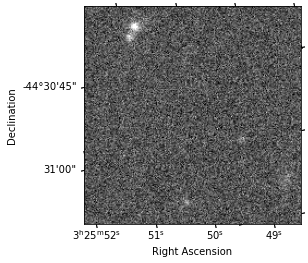

In [52]:
# now try to make the cutout using butler

print(visits['ccdVisitId'][0])
datasetType = 'calexp'

#data id for calexp are structured as visit and detector. 
dataId = {'visit': ccdvisit['visitId'][0], 'detector': ccdvisit['detector'][0]}
calexp = butler.get(datasetType, dataId=dataId)

#fig = plt.figure()

# Set the figure's projection to be the WCS of the calexp
plt.subplot(projection=WCS(calexp.getWcs().getFitsMetadata()))

# Define the extent in pixel coordinates using the bounding box
calexp_extent = (calexp.getBBox().beginX, calexp.getBBox().endX,
                 calexp.getBBox().beginY, calexp.getBBox().endY)

centerx = int(calexp.getBBox().endX / 2.)
centery = int(calexp.getBBox().endY / 2.)
print(calexp_extent)
print(centerx,centery)

# length in pixels of the side of image
figside = 100

subfig = calexp.image.array[centerx-figside:centerx+figside, centery-figside:centery+figside]#[centery-1000:centery+1000]
# Display the calexp image data array using the gray colormap (cmap)
#  and use approximately the same min and max scale values as above
#im = plt.imshow(calexp.image.array, cmap='gray', vmin=-200.0, vmax=400,
#                extent=calexp_extent, origin='lower')

print(calexp.image.array.shape)
im = plt.imshow(subfig, cmap='gray', vmin=-200.0, vmax=400,origin='lower')

plt.xlabel('Right Ascension')
plt.ylabel('Declination')
plt.show()


#fig = plt.figure()
#display = afwDisplay.Display(frame=fig)
#display.scale('asinh', 'zscale')
#display.mtv(calexp.image)
plt.show()



In [17]:
#Now try to loop over the 


2036

In [ ]:
# the following is testing junk

# now try to make the cutout using butler
radec = lsst.geom.SpherePoint(ra*lsst.geom.degrees,dec*lsst.geom.degrees)

skymap = butler.get('skyMap')
#cutout = cutout_coadd(butler, ra, dec, band='g', datasetType='deepCoadd', cutoutSideLength=1000)

# To get the visits used to contruct the deepCoadd
#unique_visits = list(set([i['visit'] for i in cutout.getInfo().getCoaddInputs().ccds]))


# Look up the tract, patch for the RA, Dec 
# Looks like tract and patch are NOT identifiers used for calexp. Must be DeepCoadd only
tractInfo = skymap.findTract(radec)
my_patch = tractInfo.findPatch(radec)

# note you can't specify both band and visit, because a visit only observes in 1 band
#dataId = {'visit': visits['ccdVisitId'][0], 'detector': 175}#, 'tract': tractInfo, 'patch': my_patch}

# The above has some error related to the visit #, so try test obs from tutorial 04b:
dataId = {'visit': 192350, 'detector': 175}
print(butler.registry.getDatasetType('calexp'))


# Select a position at roughly the center of the galaxy cluster:
cutout_image = cutout_coadd(butler, ra, dec, datasetType='calexp',
                            cutoutSideLength=50, dataId=dataId)

print(cutout_image.image)
#fig, ax = plt.subplots()
#display = afwDisplay.Display(frame=fig)
#display.scale('asinh', 'zscale')
#display.mtv(cutout_image.image)
#plt.imshow(cutout_image.image)
#plt.show()
#remove_figure(fig)
np.shape(cutout_image.image)

# deep coadd, we dont' want this because we want the individual time slices
#my_deepCoadd = butler.get('deepCoadd', dataId=dataId)
# datasetType of calexp = processed visit images, we want this for time series
#exposures = butler.get('calexp', dataId=dataId)

#xy = geom.PointI(tractInfo.getWcs().skyToPixel(radec))
#bbox = geom.BoxI(xy - cutoutSize // 2, cutoutSize)
#patch = tractInfo.getSequentialPatchIndex(patchInfo)

#coaddId = {'tract': tractInfo.getId(), 'patch': patch, 'band': band}
#parameters = {'bbox': bbox}

#cutout_image = butler.get(datasetType, parameters=parameters,
#                           dataId=coaddId)

In [ ]:
cutout_image.image[1]